In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Configuration
TOTAL_ROWS = 10000
NORMAL_RATIO = 0.7
BASE_LAT, BASE_LON = 28.6129, 77.2295  # New Delhi

# Generate core dataset
timestamps = [datetime.now() + timedelta(seconds=i) for i in range(TOTAL_ROWS)]
df = pd.DataFrame({
    'timestamp': timestamps,
    'latitude': BASE_LAT + np.cumsum(np.random.normal(0, 0.0001, TOTAL_ROWS)),
    'longitude': BASE_LON + np.cumsum(np.random.normal(0, 0.0001, TOTAL_ROWS)),
    'altitude(m)': np.clip(50 + np.cumsum(np.random.normal(0.2, 3, TOTAL_ROWS)), 10, 500), # Corrected line: moved closing parenthesis
    'speed(m/s)': np.clip(10 + np.random.normal(0, 1, TOTAL_ROWS), 0, 25),
    'yaw': np.random.normal(0, 5, TOTAL_ROWS),
    'pitch': np.random.normal(0, 2, TOTAL_ROWS),
    'roll': np.random.normal(0, 2, TOTAL_ROWS),
    'label': 0
})

# Inject 30% anomalies
attack_indices = np.random.choice(
    TOTAL_ROWS,
    int(TOTAL_ROWS * (1 - NORMAL_RATIO)),
    replace=False
)

for idx in attack_indices:
    attack_type = np.random.choice(['kamikaze', 'gps_spoof', 'erratic'])
    duration = np.random.randint(5, 15)

    # Ensure we don't exceed dataframe bounds
    end_idx = min(idx + duration, TOTAL_ROWS - 1)
    actual_duration = end_idx - idx + 1

    if attack_type == 'kamikaze':
        df.loc[idx:end_idx, 'altitude(m)'] = np.linspace(
            df.at[idx, 'altitude(m)'],
            np.random.uniform(5, 20),
            num=actual_duration
        )
        df.loc[idx:end_idx, 'speed(m/s)'] = np.linspace(
            df.at[idx, 'speed(m/s)'],
            np.random.uniform(30, 50),
            num=actual_duration
        )

    elif attack_type == 'gps_spoof':
        df.loc[idx:end_idx, 'latitude'] += np.random.uniform(0.005, 0.02, size=actual_duration)
        df.loc[idx:end_idx, 'longitude'] += np.random.uniform(0.005, 0.02, size=actual_duration)

    else:  # erratic
        df.loc[idx:end_idx, 'yaw'] = np.random.uniform(-90, 90, size=actual_duration)
        df.loc[idx:end_idx, 'pitch'] = np.random.uniform(-45, 45, size=actual_duration)

    df.loc[idx:end_idx, 'label'] = 1

df.to_csv("military_drone_70-30.csv", index=False)
print("Dataset generated successfully!")

Dataset generated successfully!


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('military_drone_70-30.csv')

In [4]:
# Display basic info
print(df.info())
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   timestamp    10000 non-null  object 
 1   latitude     10000 non-null  float64
 2   longitude    10000 non-null  float64
 3   altitude(m)  10000 non-null  float64
 4   speed(m/s)   10000 non-null  float64
 5   yaw          10000 non-null  float64
 6   pitch        10000 non-null  float64
 7   roll         10000 non-null  float64
 8   label        10000 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 703.3+ KB
None
label
1    9727
0     273
Name: count, dtype: int64


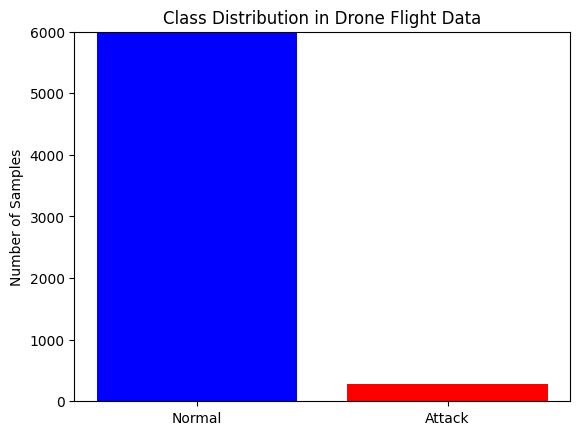

In [5]:
import matplotlib.pyplot as plt

# Assuming `df` is your DataFrame
class_counts = df['label'].value_counts()

plt.bar(['Normal', 'Attack'], class_counts, color=['blue', 'red'])
plt.title('Class Distribution in Drone Flight Data')
plt.ylabel('Number of Samples')
plt.ylim(0, 6000)  # Adjust if counts exceed 5000
plt.show()

In [6]:
from sklearn.ensemble import RandomForestClassifier
X = df.drop(['label', 'timestamp'], axis=1) # Drop the 'timestamp' column
y = df['label']
model = RandomForestClassifier().fit(X, y)

In [7]:
# Convert 'timestamp' column to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Now, proceed with feature engineering
df['acceleration'] = df['speed(m/s)'].diff() / df['timestamp'].diff().dt.total_seconds()
df['altitude_change'] = df['altitude(m)'].diff()
df['direction_change'] = df['yaw'].diff().abs()

In [8]:
# Drop the first row with NaN values from differencing
df = df.dropna()

In [9]:
# Select features
features = ['latitude', 'longitude', 'altitude(m)', 'speed(m/s)',
            'yaw', 'pitch', 'roll', 'acceleration',
            'altitude_change', 'direction_change']
X = df[features]
y = df['label']

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [13]:
# Make predictions
y_pred = model.predict(X_test_scaled)

In [14]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.992

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        77
           1       0.99      1.00      1.00      2923

    accuracy                           0.99      3000
   macro avg       0.93      0.90      0.92      3000
weighted avg       0.99      0.99      0.99      3000



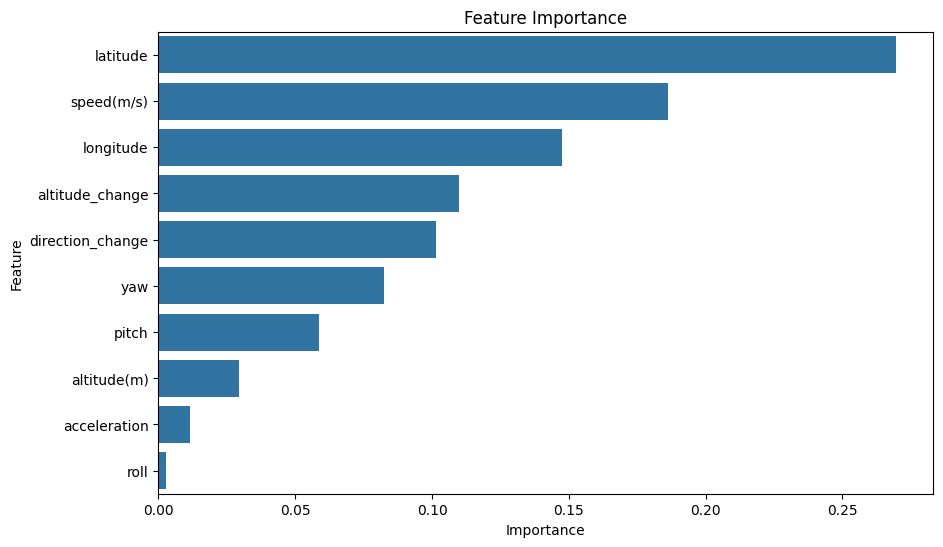

In [15]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [16]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np

# Make predictions on test set
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Accuracy: 0.9920

Confusion Matrix:
[[  62   15]
 [   9 2914]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        77
           1       0.99      1.00      1.00      2923

    accuracy                           0.99      3000
   macro avg       0.93      0.90      0.92      3000
weighted avg       0.99      0.99      0.99      3000



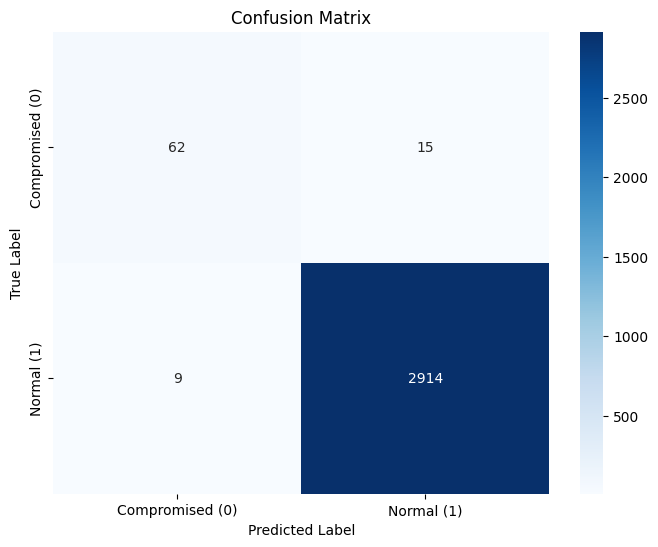

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Compromised (0)', 'Normal (1)'],
            yticklabels=['Compromised (0)', 'Normal (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

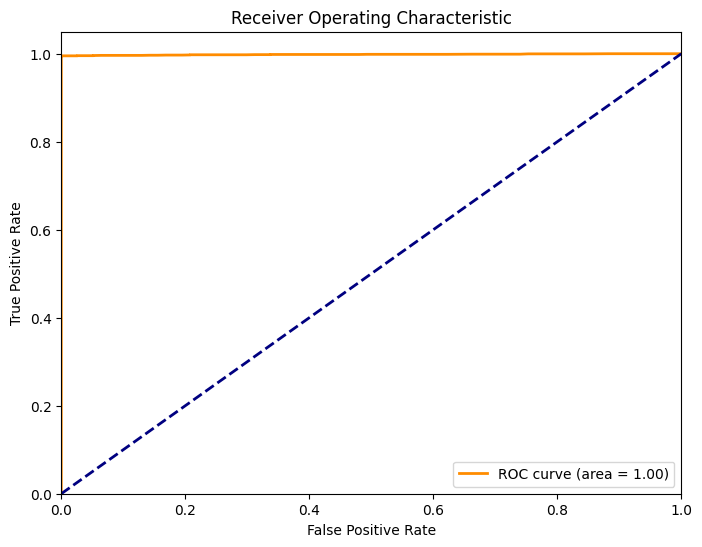

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

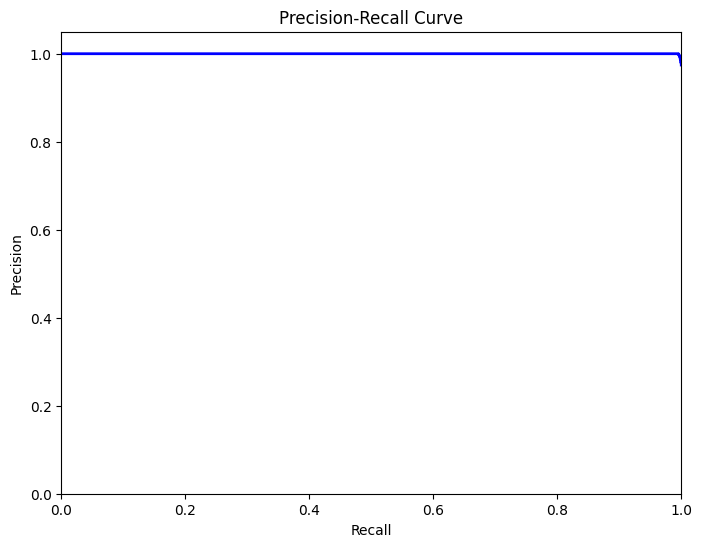

In [19]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

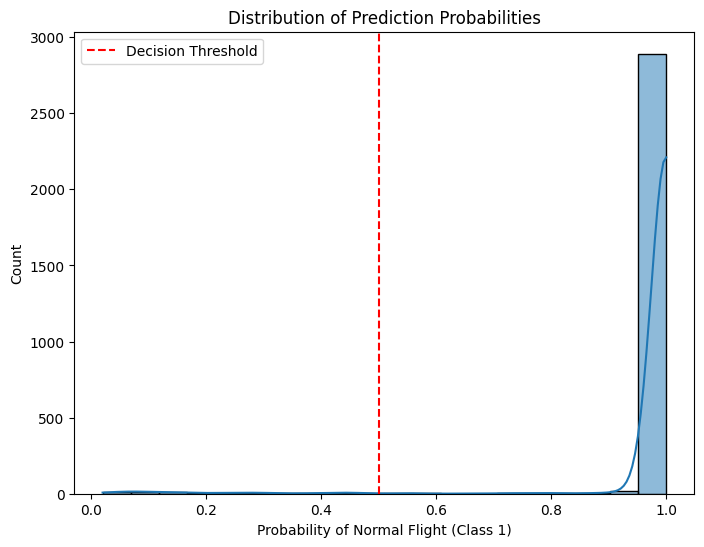

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, bins=20, kde=True)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.title('Distribution of Prediction Probabilities')
plt.xlabel('Probability of Normal Flight (Class 1)')
plt.ylabel('Count')
plt.legend()
plt.show()

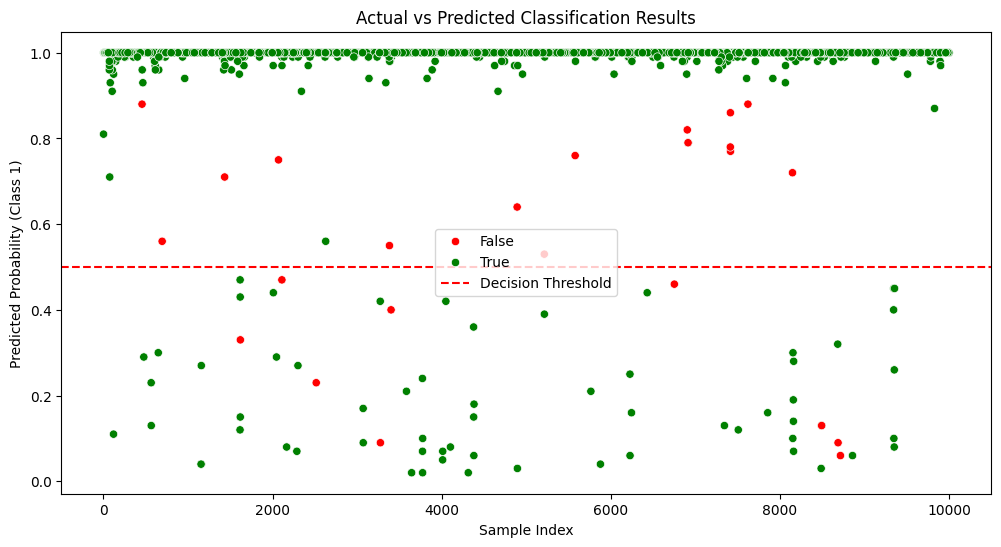

In [21]:
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_pred_proba})
results['Correct'] = results['Actual'] == results['Predicted']

plt.figure(figsize=(12, 6))
sns.scatterplot(x=X_test.index, y='Probability', hue='Correct', data=results, palette={True: 'green', False: 'red'})
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.title('Actual vs Predicted Classification Results')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability (Class 1)')
plt.legend()
plt.show()

In [22]:
import joblib

# Save the model and scaler
joblib.dump(model, 'drone_classifier_model.pkl')
joblib.dump(scaler, 'drone_scaler.pkl')

['drone_scaler.pkl']

In [23]:
import pandas as pd
import joblib

def load_models():
    """Load the pre-trained model and scaler"""
    model = joblib.load('drone_classifier_model.pkl')
    scaler = joblib.load('drone_scaler.pkl')
    return model, scaler

def predict_flight_status(new_data):
    """
    Predict whether drone flight is normal (1) or compromised (0)

    Parameters:
    new_data (DataFrame or dict): New flight data with same features as training

    Returns:
    tuple: (prediction, probability, confidence_level)
    """
    # Load models
    model, scaler = load_models()

    # Convert dict to DataFrame if needed
    if isinstance(new_data, dict):
        new_data = pd.DataFrame([new_data])

    # Ensure all required features are present
    required_features = ['latitude', 'longitude', 'altitude(m)', 'speed(m/s)',
                        'yaw', 'pitch', 'roll', 'acceleration',
                        'altitude_change', 'direction_change']

    # Calculate any missing derived features
    if 'acceleration' not in new_data.columns:
        new_data['acceleration'] = new_data['speed(m/s)'].diff()

    if 'altitude_change' not in new_data.columns:
        new_data['altitude_change'] = new_data['altitude(m)'].diff()

    if 'direction_change' not in new_data.columns:
        new_data['direction_change'] = new_data['yaw'].diff().abs()

    # Select only the required features
    new_data = new_data[required_features].dropna()

    # Scale the new data
    new_data_scaled = scaler.transform(new_data)

    # Make prediction
    prediction = model.predict(new_data_scaled)
    probabilities = model.predict_proba(new_data_scaled)

    # Calculate confidence
    confidence = probabilities[0][prediction[0]] * 100  # as percentage

    return prediction[0], probabilities[0], confidence

Testing the model: Inputing flight data and expecting prediction whether the drone is still functioning normally or has gone rogue.


In [26]:
import pandas as pd
from io import StringIO

# Assuming you have a predict_flight_status function defined elsewhere
# from your_module import predict_flight_status

def process_flight_data(file_content):
    """
    Process the uploaded flight data file and return predictions
    """
    try:
        # Read the data into a DataFrame
        flight_df = pd.read_csv(StringIO(file_content))

        # Calculate derived features
        flight_df['acceleration'] = flight_df['speed(m/s)'].diff()
        flight_df['altitude_change'] = flight_df['altitude(m)'].diff()
        flight_df['direction_change'] = flight_df['yaw'].diff().abs()

        # Get prediction for most recent reading
        if len(flight_df) > 0:
            prediction, probabilities, confidence = predict_flight_status(flight_df.iloc[-1:])
            return {
                'status': 'Normal' if prediction == 1 else 'Rogue',
                'confidence': f"{confidence:.2f}%",
                'probabilities': {
                    'Rogue': f"{probabilities[0]:.4f}",
                    'Normal': f"{probabilities[1]:.4f}"
                },
                'data_points_processed': len(flight_df)
            }
        else:
            return {'error': 'No valid data found in the file'}

    except Exception as e:
        return {'error': f'Error processing file: {str(e)}'}

def main():
    print("Drone Flight Status Classifier")
    print("Upload a text file with flight data in the following format:")
    print("latitude,longitude,altitude(m),speed(m/s),yaw,pitch,roll")
    print("28.613938,79.229020,53.40,55.00,-13.20,1.00,-0.58")
    print("28.613939,73.229021,63.48,100.10,-13.23,1.02,-0.60")
    print("\n")

    file_path = input("Enter the path to your flight data file: ")

    try:
        with open(file_path, 'r') as file:
            file_content = file.read()

        result = process_flight_data(file_content)

        if 'error' in result:
            print(f"Error: {result['error']}")
        else:
            print("\nClassification Results:")
            print(f"Status: {result['status']}")
            print(f"Confidence: {result['confidence']}")
            print(f"Probability (Rogue): {result['probabilities']['Rogue']}")
            print(f"Probability (Normal): {result['probabilities']['Normal']}")
            print(f"Data points processed: {result['data_points_processed']}")

    except FileNotFoundError:
        print("Error: File not found. Please check the path and try again.")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Drone Flight Status Classifier
Upload a text file with flight data in the following format:
latitude,longitude,altitude(m),speed(m/s),yaw,pitch,roll
28.613938,79.229020,53.40,55.00,-13.20,1.00,-0.58
28.613939,73.229021,63.48,100.10,-13.23,1.02,-0.60


Enter the path to your flight data file: /content/DroneRogue.txt

Classification Results:
Status: Normal
Confidence: 98.00%
Probability (Rogue): 0.0200
Probability (Normal): 0.9800
Data points processed: 6
